# Logistic Regression for real data

This time we used data without removing consecutive rows with the same value of Mid-Price Indicator.

The results are much much worse.

In [50]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import linear_model
from sklearn import svm
from scipy import stats

from mlxtend.plotting import plot_decision_regions

from ast import literal_eval

import warnings

from collections import OrderedDict

from lob_data_utils import lob, model, roc_results, gdf_pca, lob_classify, stocks
from lob_data_utils.svm_calculation import lob_svm

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
data_dir = 'data/prepared'
should_savefig = False

In [52]:
choosen_stocks = pd.read_csv('choosen_stocks.csv').values[:, 1]
df_stocks = pd.read_csv('stocks.csv')
df_res = pd.read_csv('res_log_que.csv')
df_res = pd.merge(df_res, df_stocks, on='stock')
columns = ['stock', 'is_choosen', 'mid_price_indicator_ratio'] + [
    c for c in df_res.columns if 'matt' in c or 'roc' in c]
df_res.columns

Index(['Unnamed: 0_x', 'class_weights', 'f1', 'kappa', 'kernel', 'matthews',
       'precision', 'recall', 'roc_auc', 'stock', 'test_f1', 'test_kappa',
       'test_matthews', 'test_precision', 'test_recall', 'test_roc_auc',
       'train_f1', 'train_kappa', 'train_matthews', 'train_precision',
       'train_recall', 'train_roc_auc', 'train_val_f1', 'train_val_kappa',
       'train_val_matthews', 'train_val_precision', 'train_val_recall',
       'train_val_roc_auc', 'Unnamed: 0_y', 'mean_mid_price', 'mean_spread',
       'mid_price_indicator_ratio', 'test_length', 'test_mean_mid_price',
       'test_mean_spread', 'test_mid_price_indicator_ratio', 'train_length',
       'diff_mean_mid_price', 'diff_mid_price_indicator_ratio',
       'diff_mean_spread', 'km', 'is_choosen'],
      dtype='object')

### Columns

Scores: f1, kappa, roc auc, matthews, recall, precision for test, val (without indicator f.e. `matthews`), train during validation (`train_val`), train.

Mean mid price and mean spread for test and training set (we need to know these to know if testing set has similar distribution):
`mean_mid_price`, `mean_spread`, `test_mean_mid_price`, `test_mean_spread`

differences between training and testing set:
`diff_mean_mid_price`, `diff_mid_price_indicator_ratio` `diff_mean_spread`

Lengths of training and testing set (not important):
`train_length`, `test_length`

The ratio between number of postivies and negatives for training and testing set:
`mid_price_indicator_ratio` and `test_mid_price_indicator_ratio`

Cluster to which stock belongs (clustered using mean mid price and mean spread), there are 3 clusters: `km`
If we pick it for further calculations (5 per cluster): `is_choosen` 

In [53]:
print('mcc', len(df_res[df_res['matthews'] > 0.0][columns]), 'per', len(df_res['stock'].unique()))
print('roc_auc', len(df_res[df_res['roc_auc'] > 0.5][columns]), 'per', len(df_res['stock'].unique()))
df_res[df_res['matthews'] > 0.0][columns]

mcc 101 per 98
roc_auc 101 per 98


,stock,is_choosen,mid_price_indicator_ratio,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,train_val_matthews,train_val_roc_auc
0,9269,0,0.671214,0.100470,0.550638,0.100352,0.551749,0.094565,0.548218,0.089307,0.545330
1,3022,0,0.460191,0.113407,0.560990,0.115565,0.560573,0.115502,0.562168,0.107777,0.557860
2,2051,0,0.189021,0.118968,0.579171,0.115094,0.577213,0.122543,0.583414,0.123845,0.584607
3,3879,0,0.399732,0.137354,0.576551,0.120553,0.565858,0.136157,0.575203,0.139540,0.576524
4,10166,0,0.685265,0.120872,0.561400,0.110543,0.555460,0.108777,0.555355,0.104679,0.553257
5,1080,0,0.174771,0.133942,0.591948,0.142380,0.597513,0.123861,0.586375,0.128519,0.589466
6,12059,0,0.655184,0.128926,0.565861,0.079754,0.540686,0.115285,0.558947,0.107477,0.554980
7,1907,0,0.398463,0.140511,0.576996,0.144115,0.581091,0.145256,0.580300,0.144274,0.579732
8,2050,0,0.259975,0.139848,0.585798,0.153529,0.588963,0.135503,0.583516,0.136887,0.584427
9,2050,0,0.259975,0.139848,0.585798,0.153529,0.588963,0.135503,0.583516,0.136887,0.584427


In [54]:
df_res[df_res['stock'].isin(choosen_stocks)][columns].sort_values(by='mid_price_indicator_ratio')

,stock,is_choosen,mid_price_indicator_ratio,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,train_val_matthews,train_val_roc_auc
22,2748,1,0.167196,0.143627,0.592444,0.134270,0.596587,0.105855,0.575097,0.101212,0.569234
81,4851,1,0.172410,0.141509,0.602119,0.138680,0.600747,0.146122,0.601755,0.151100,0.603678
20,3459,1,0.243203,0.120196,0.576229,0.130774,0.581522,0.129963,0.581691,0.137011,0.585500
58,10470,1,0.340178,0.136879,0.578000,0.126946,0.571430,0.129243,0.574360,0.126299,0.572930
31,11869,1,0.372354,0.120455,0.566097,0.105285,0.557722,0.119060,0.567023,0.116874,0.565572
67,4799,1,0.375902,0.123985,0.569671,0.124435,0.570149,0.111598,0.562566,0.109588,0.561039
28,12255,1,0.382685,0.140048,0.578323,0.111629,0.562531,0.123718,0.568951,0.122741,0.568086
64,4549,1,0.409391,0.122816,0.567216,0.133548,0.574059,0.119528,0.565663,0.119832,0.565801
35,9761,1,0.421796,0.146427,0.579966,0.107514,0.558467,0.125276,0.568539,0.125167,0.568139
27,9268,1,0.443725,0.116182,0.563328,0.132175,0.571607,0.122804,0.566503,0.122135,0.566085


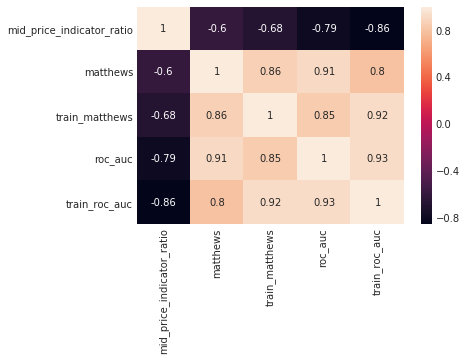

In [55]:
sns.heatmap(
    df_res[['mid_price_indicator_ratio', 'matthews', 'train_matthews', 'roc_auc', 'train_roc_auc']].corr(), 
    annot=True)

The scores we obtained are highly correlated with `mid_price_indicator_ratio`...

Logistic Regression does not work well if the classes are imbalanced.

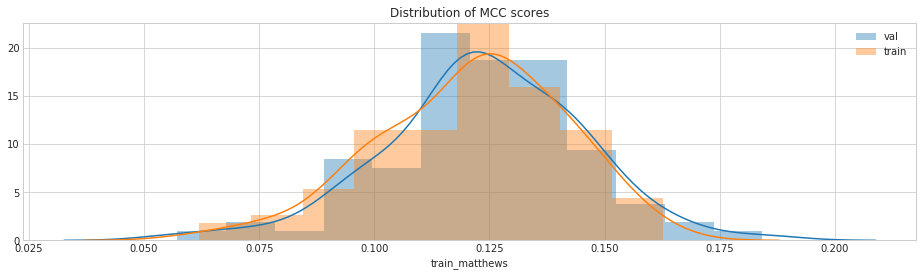

In [56]:
plt.figure(figsize=(16, 4))
sns.distplot(df_res['matthews'], label='val')
sns.distplot(df_res['train_matthews'], label='train')
plt.title('Distribution of MCC scores')
plt.legend()

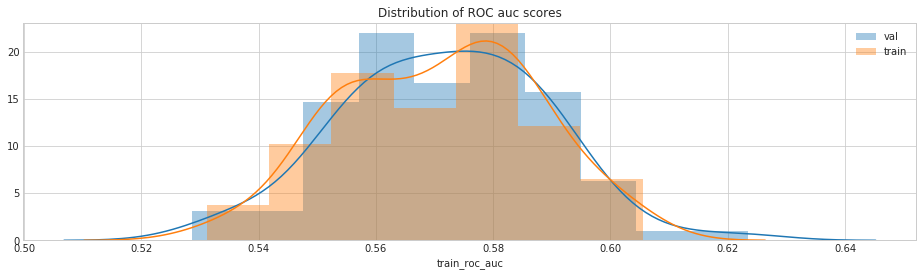

In [57]:
plt.figure(figsize=(16, 4))
sns.distplot(df_res['roc_auc'], label='val')
sns.distplot(df_res['train_roc_auc'], label='train')
plt.title('Distribution of ROC auc scores')
plt.legend()

## Conclusion



In [60]:
df_res[df_res['stock'] == 9761]['test_matthews']

35    0.107514
Name: test_matthews, dtype: float64